# Figure 2- Animals Reach Fixation Target in Significantly Less Time


# Libraries


In [5]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu

sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

# Data Load


In [48]:
tdf = u.load_trials_df()
tdf = u.compute_days_relative_to_stage(tdf, 5) # compute days relative to stage 5

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Utility Functions


In [87]:
def make_fixation_growth_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make a dataframe with the max fixation duration for each animal_id, date
    and the change in fixation duration from the previous day
    """

    max_fixation_df = (
        df.query("stage >=5")  # only look at cpoking stages
        .groupby(
            [
                "date",
                "animal_id",
                "stage",
                f"days_relative_to_stage_5",
                "fix_experiment",
            ],
            observed=True,
        )
        .agg(
            max_fixation_dur=("fixation_dur", "max"),
            trials=("trial", "nunique"),
            n_violations=("violations", "sum"),
            n_settling_ins=("n_settling_ins", "sum"),
        )
        .reset_index()
    )
    max_fixation_df["valid_trials"] = (
        max_fixation_df["trials"] - max_fixation_df["n_violations"]
    )
    max_fixation_df.drop(columns=["n_violations"], inplace=True)

    # Compute the difference in fixation duration from the previous day
    max_fixation_df["fixation_growth"] = max_fixation_df.groupby(
        "animal_id"
    ).max_fixation_dur.diff()

    return max_fixation_df

# A


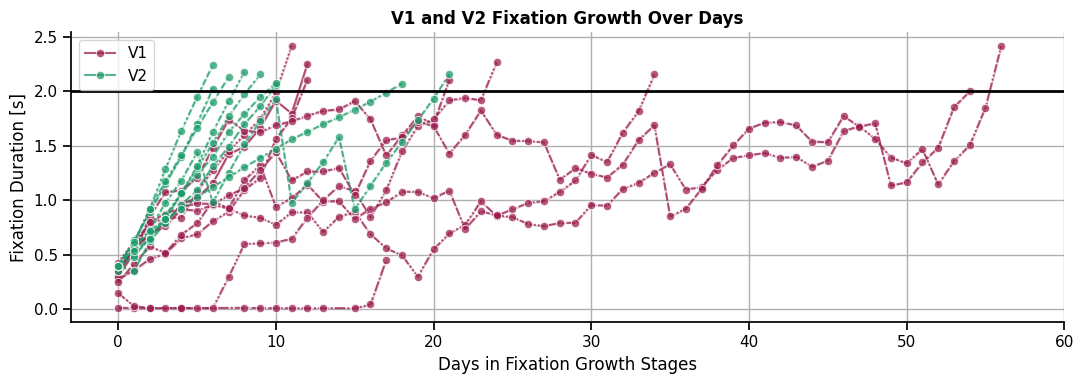

In [66]:
fig, ax = plt.subplots(figsize=(11, 4))
plot_df = tdf.query("stage in @c.GROWING_STAGES")

sns.lineplot(
    data=plot_df,
    x="days_relative_to_stage_5",
    y="fixation_dur",
    estimator="max",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    palette=c.EXP_PALETTE,
    style="animal_id",
    marker="o",
    alpha=0.75
)
ax.grid()
ax.axhline(2, color="k", lw=2)
_ = ax.set(ylabel="Fixation Duration [s]", xlabel="Days in Fixation Growth Stages", xlim=(-3, 60))
ax.set_title("V1 and V2 Fixation Growth Over Days", fontweight="bold")

sns.despine()

# Remove the default legend with style information
ax.get_legend().remove()
# Add a new legend with only the hue information
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3])
plt.tight_layout()
fig.savefig("figures/V0_fig2a_fix_dur_over_days.png", dpi=300, bbox_inches="tight")

# B


In [68]:
plot_df = (
    tdf.query("has_reached_target_fixation == True")
    .groupby(["animal_id", "fix_experiment"], observed=True)[
        f"days_relative_to_stage_5"
    ]
    .min()
    .reset_index()
)

plot_df.rename(
    columns={f"days_relative_to_stage_5": "days_to_target"},
    inplace=True,
)

stats = plot_df.groupby('fix_experiment')['days_to_target'].agg(['median', 'mean', 'std', 'size'])
stats

,median,mean,std,size
fix_experiment,,,,
V1,23.5,29.000000,18.369229,8
V2,10.0,11.444444,5.456902,9


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


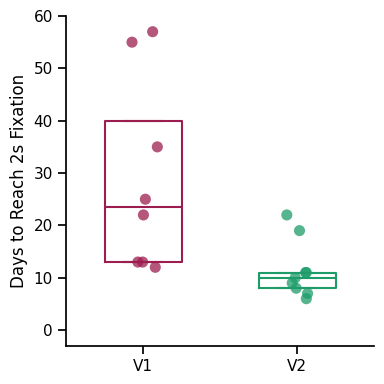

In [74]:
fig, ax = plt.subplots(figsize=(4,4))

u.box_strip_v1_vs_v2(plot_df, x="fix_experiment", order=c.HUE_ORDER_EXP, y="days_to_target", ax=ax, xlabel="", ylabel="Days to Reach 2s Fixation", s=8)
ax.set_ylim(-3, 60)
# ax.set_title("Days to Reach Target", fontweight="bold")
plt.tight_layout()

#save fig
fig.savefig("figures/V0_fig2b_days_to_target_summary.png", dpi=300, bbox_inches="tight")

In [65]:
u.compare_v1_v2(plot_df, "days_to_target")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,False,8,9,mannwhitney,65.5,0.005179


In [73]:
from statsmodels.stats.power import TTestIndPower

# Separate by condition
group_V1 = plot_df[plot_df["fix_experiment"] == "V1"]["days_to_target"]
group_V2 = plot_df[plot_df["fix_experiment"] == "V2"]["days_to_target"]

# Convert to numpy arrays (optional but often convenient)
group_V1 = group_V1.values
group_V2 = group_V2.values

mean_V1 = np.mean(group_V1)
mean_V2 = np.mean(group_V2)
std_V1 = np.std(group_V1, ddof=1)  # ddof=1 for sample SD
std_V2 = np.std(group_V2, ddof=1)

n1 = len(group_V1)
n2 = len(group_V2)

print(f"V1 mean: {mean_V1:.3f}, std: {std_V1:.3f}, n: {n1}")
print(f"V2 mean: {mean_V2:.3f}, std: {std_V2:.3f}, n: {n2}")

# Variances

var_V1 = std_V1**2
var_V2 = std_V2**2

# Pooled standard deviation
pooled_var = ((n1 - 1) * var_V1 + (n2 - 1) * var_V2) / (n1 + n2 - 2)
pooled_std = np.sqrt(pooled_var)

# Cohen's d
effect_size = (mean_V1 - mean_V2) / pooled_std

print(f"Pooled Std Dev:, {pooled_std:.3f}")
print(f"Effect size (Cohen's d): {effect_size:.3f}")

analysis = TTestIndPower()

# ratio = n2 / n1
ratio = n2 / n1

# Calculate power
power = analysis.power(
    effect_size=effect_size, nobs1=n1, alpha=0.05, ratio=ratio, alternative="two-sided"
)

print(f"Observed power: {power:.4f}")

V1 mean: 29.000, std: 18.369, n: 8
V2 mean: 11.444, std: 5.457, n: 9
Pooled Std Dev:, 13.166
Effect size (Cohen's d): 1.333
Observed power: 0.7275


# C

[ ] Ae: make the right size, crop to 30 days?, x labels, y labels is Seconds, labels
inside

[ ] Ae: title similar to A: v1 and v2 session fixation delta


In [ ]:
fixation_growth_df = make_fixation_growth_df(tdf.query("stage in @c.GROWING_STAGES").copy())

,date,animal_id,stage,days_relative_to_stage_5,fix_experiment,max_fixation_dur,trials,n_settling_ins,valid_trials,fixation_growth
344,2024-10-02,R052,7.0,55,V1,1.851762,301,302.0,278,0.346134
345,2024-10-02,R056,7.0,52,V1,1.483112,328,328.0,274,0.135301
346,2024-10-03,R052,7.0,56,V1,2.418070,388,388.0,337,0.566307
347,2024-10-03,R056,7.0,53,V1,1.855338,361,362.0,295,0.372226
348,2024-10-04,R056,7.0,54,V1,2.000135,241,241.0,197,0.144797


In [149]:
"""Ttest Stats Over Days"""

def compare_fixation_growth_by_day(df, max_days):
    number_of_tests = max_days
    results = {}

    for day in range(1, max_days + 1):
        day_data = df[df["days_relative_to_stage_5"] == day]
        
        group_v1 = day_data[day_data["fix_experiment"] == "V1"]["fixation_growth"].dropna()
        group_v2 = day_data[day_data["fix_experiment"] == "V2"]["fixation_growth"].dropna()
        
        # Check normality
        normality_v1 = shapiro(group_v1).pvalue > 0.05 if len(group_v1) >= 3 else False
        normality_v2 = shapiro(group_v2).pvalue > 0.05 if len(group_v2) >= 3 else False

        if len(group_v1) == 0 or len(group_v2) == 0:
            test_type = "insufficient data"
            stat, p_val = np.nan, np.nan
        else:
            test_type = "mann-whitney"
            stat, p_val = mannwhitneyu(group_v1, group_v2, alternative='two-sided')
        
        p_adj = min(p_val * number_of_tests, 1.0) if not np.isnan(p_val) else np.nan

        results[day] = {
            "test_type": test_type,
            "stat": stat,
            "p_value": p_val,
            "p_adj": p_adj,
            "normality_v1": normality_v1,
            "normality_v2": normality_v2
        }

        signif_str = "**SIGNIFICANT**" if p_adj < 0.05 else ""
        print(f"Day {day} [{test_type}]: {signif_str}")
        print(f"  Normality V1: {normality_v1}, Normality V2: {normality_v2}")
        print(f"  Stat = {stat:.3f}, p = {p_val:.3e}, Bonferroni adj p = {p_adj:.3e}\n")
    
    return results


Day 1 [mann-whitney]: 
  Normality V1: False, Normality V2: True
  Stat = 42.000, p = 9.296e-01, Bonferroni adj p = 1.000e+00

Day 2 [mann-whitney]: 
  Normality V1: True, Normality V2: True
  Stat = 22.000, p = 1.120e-01, Bonferroni adj p = 7.837e-01

Day 3 [mann-whitney]: **SIGNIFICANT**
  Normality V1: True, Normality V2: True
  Stat = 6.000, p = 2.468e-03, Bonferroni adj p = 1.728e-02

Day 4 [mann-whitney]: **SIGNIFICANT**
  Normality V1: False, Normality V2: True
  Stat = 6.000, p = 2.680e-03, Bonferroni adj p = 1.876e-02

Day 5 [mann-whitney]: **SIGNIFICANT**
  Normality V1: True, Normality V2: True
  Stat = 5.000, p = 1.563e-03, Bonferroni adj p = 1.094e-02

Day 6 [mann-whitney]: 
  Normality V1: True, Normality V2: False
  Stat = 19.000, p = 1.139e-01, Bonferroni adj p = 7.976e-01

Day 7 [mann-whitney]: 
  Normality V1: True, Normality V2: True
  Stat = 20.000, p = 3.969e-01, Bonferroni adj p = 1.000e+00



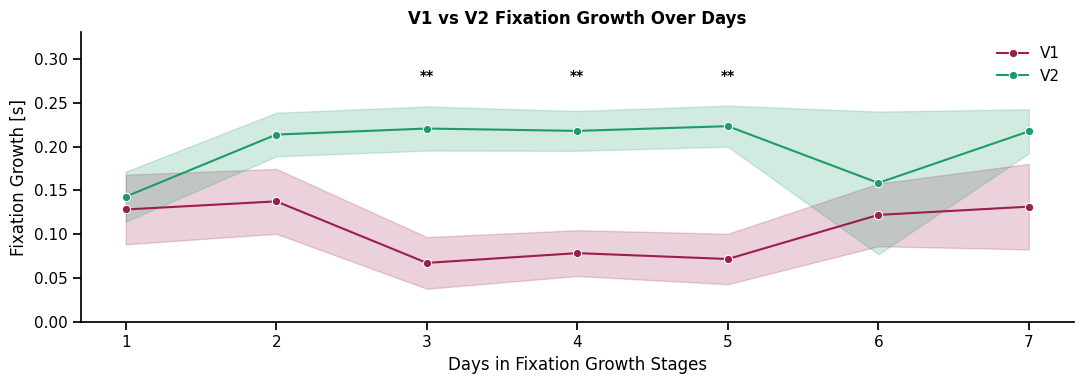

In [154]:
fig, ax = plt.subplots(figsize=(11,4))
MAX_DAYS = 7
res = compare_fixation_growth_by_day(fixation_growth_df, MAX_DAYS)
plot_df = fixation_growth_df.query("days_relative_to_stage_5 <= @MAX_DAYS")

sns.lineplot(
    data=plot_df,
    x="days_relative_to_stage_5",
    y="fixation_growth",
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    palette=c.EXP_PALETTE,
    marker="o",
    ax=ax,
    errorbar="se",
)
ax.set_title(f"V1 vs V2 Fixation Growth Over Days", fontweight="bold")
ax.legend(frameon=False)
ax.set(ylim=(0 , 0.33), ylabel="Fixation Growth [s]", xlabel="Days in Fixation Growth Stages")

y_annot = 0.28 # x-value for annotation
for day, stats in res.items():
    p_val = stats["p_value"]
    if p_val < 0.05:
        if p_val < 0.001:
            star = "***"
        elif p_val < 0.01:
            star = "**"
        else:
            star = "*"
        # Add a star annotation at the given x coordinate and the day's y coordinate
        ax.text(day, y_annot, star, fontsize=10, color="k", va="center", ha="center", fontweight="bold")
sns.despine()
plt.tight_layout()
plt.savefig("figures/V0_fig2c_fixation_growth_over_days.png", dpi=300, bbox_inches="tight")

# D


In [135]:
plot_df = fixation_growth_df.copy()
stats = plot_df.groupby('fix_experiment')['fixation_growth'].agg(['median', 'mean', 'std', 'size'])
stats

,median,mean,std,size
fix_experiment,,,,
V1,0.066538,0.066602,0.168563,245
V2,0.199544,0.163639,0.176251,104


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


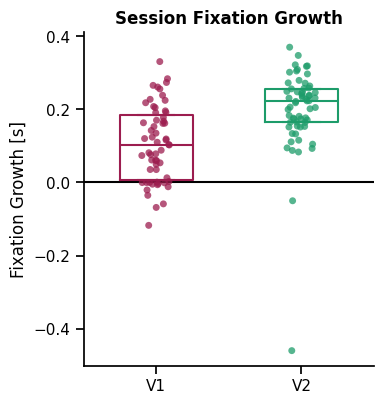

In [155]:
fig, ax = plt.subplots(figsize=(4,4))


u.box_strip_v1_vs_v2(plot_df, x="fix_experiment", order=c.HUE_ORDER_EXP, y="fixation_growth", ax=ax, xlabel="", ylabel="Fixation Growth [s]", s=5)


ax.axhline(0, color="black", zorder=0)
_ = ax.set(ylabel="Fixation Growth [s]", xlabel="")
plt.tight_layout()
ax.set_title("Session Fixation Growth", fontweight="bold")


#save fig
fig.savefig("figures/V0_fig2d_fixation_growth_summary.png", dpi=300, bbox_inches="tight")


In [141]:
u.compare_v1_v2(plot_df.dropna(subset=["fixation_growth"]), "fixation_growth")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,236,95,mannwhitney,5654.0,1.740188e-12


In [142]:
u.compare_v1_v2_multi_sample(plot_df.dropna(subset=["fixation_growth"]), "fixation_growth")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,3.08847,0.002012,False


# S3 A V1 Normative Growth


# S3 B- Days to Complete Stage 5


In [84]:
plot_df = (
    tdf.query("stage==5").groupby(["animal_id", "stage", "fix_experiment"], observed=True)
    .agg(n_days=pd.NamedAgg(column="date", aggfunc="nunique"))
    .reset_index()
)
plot_df

,animal_id,stage,fix_experiment,n_days
0,R040,5.0,V1,1
1,R041,5.0,V2,2
2,R042,5.0,V1,1
3,R043,5.0,V2,1
4,R044,5.0,V1,13
5,R045,5.0,V2,1
6,R046,5.0,V1,1
7,R047,5.0,V2,1
8,R048,5.0,V1,1
9,R049,5.0,V2,2


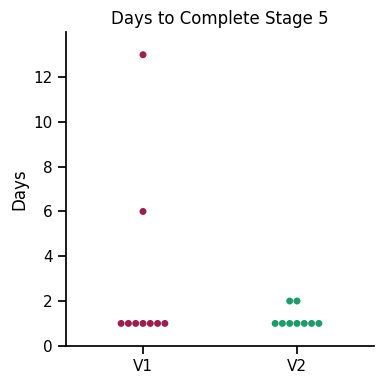

In [86]:
fig, ax = plt.subplots(figsize=(4,4))

sns.swarmplot(
    data=plot_df,
    x="fix_experiment",
    y="n_days",
    ax=ax,
    palette=c.EXP_PALETTE,
    hue="fix_experiment",
    order=c.HUE_ORDER_EXP,
)
sns.despine()

_ = ax.set_yticks(range(0, 14, 2))
_ = ax.set(ylabel="Days", xlabel="", title="Days to Complete Stage 5", ylim=(0, 14))

plt.tight_layout()
plt.savefig("figures/V0_figs3b_days_to_complete_stage_5.png", dpi=300, bbox_inches="tight")
